# mass binning

In [42]:
from   astropy.io import fits
import numpy as np
from   astropy.table import Table
import matplotlib.pyplot as plt

def file_name(obj,prefix,filetype='fits'):
    field = obj['subfield'].lower()
    id    = str(obj['ID']).zfill(5)
    return f"hlsp_clear_hst_wfc3_{field}-{id}_g102-g141_v4_{prefix}.{filetype}"

def find_data(name,hdu):
    for i,image in enumerate(hdu):
        if name == image.name:
            return i,image


obj_lis = Table.read('obj_lis_selected.fits')

bins_m = [-np.inf,9.75,10.5,np.inf]
binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)
bins_z  = [-np.inf,1.11,np.inf]
binning_z = np.digitize(obj_lis['z_MAP'],bins_z)
bin_label_m = ['8<logm<9.75','9.75<logm<10.5','10.5<logm<11.25']
bin_label_z = ['0.7<z<1.1','1.1<z<1.5']

obj_lis['bin_m'] = binning_m
obj_lis['bin_z'] = binning_z
obj_lis.write('obj_lis_selected_bins.fits',overwrite=True)
select = np.logical_and(np.logical_and(obj_lis['tag']!='agn',obj_lis['manual_select']=='keep'),obj_lis['mass']>0)

print(len(obj_lis))
print(len(obj_lis[select]))
obj_lis_sel = obj_lis[select]

/tmp/ipykernel_6650/2303710476.py:20: RuntimeWarning: invalid value encountered in log10
  binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)


158
94


/tmp/ipykernel_6650/3588489403.py:3: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(obj_lis['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)


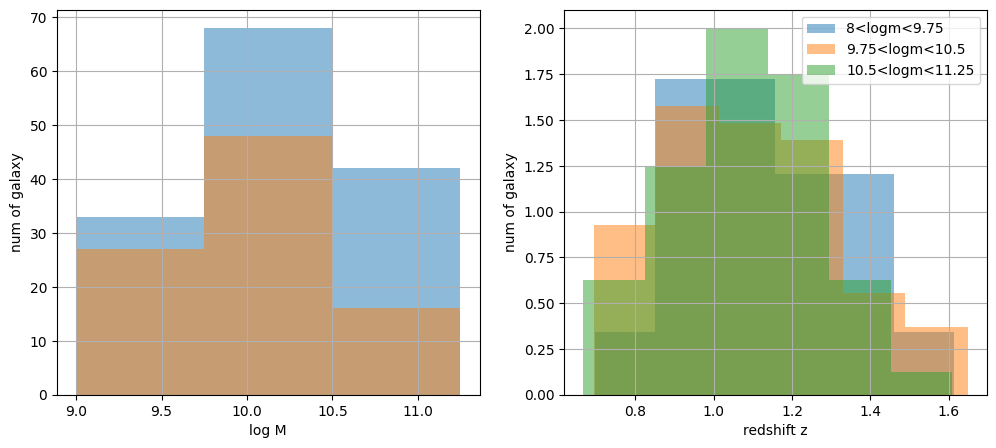

In [3]:
ax = plt.figure(figsize=(12,5))
ax.add_subplot(121)
plt.hist(np.log10(obj_lis['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)
plt.hist(np.log10(obj_lis_sel['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)
plt.xlabel('log M');plt.ylabel('num of galaxy')
plt.grid()

ax.add_subplot(122)
plt.hist(obj_lis[binning_m==1]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label_m[0])
plt.hist(obj_lis[binning_m==2]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label_m[1])
plt.hist(obj_lis[binning_m==3]['z_MAP'],bins=6,density=True,alpha=0.5,label=bin_label_m[2])
plt.xlabel('redshift z');plt.ylabel('num of galaxy')
plt.legend();plt.grid()
plt.show()


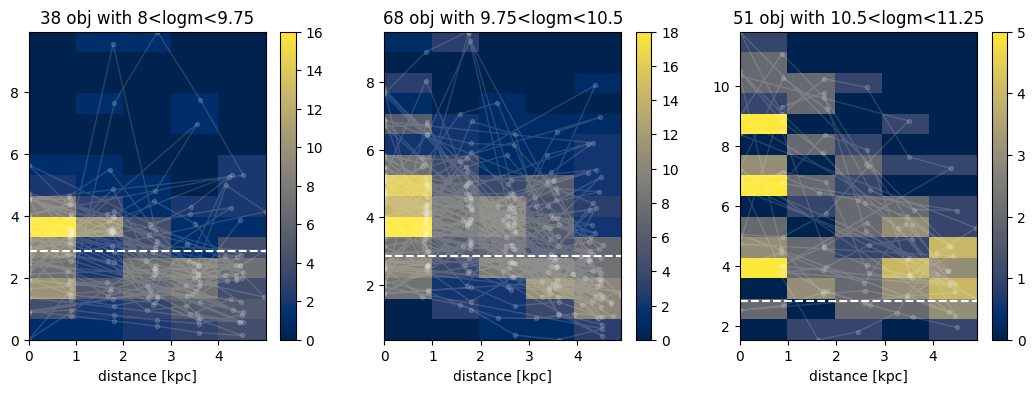

In [9]:
ax =plt.figure(figsize=(13,4))

for i in range(len(bins_m)-1):
    ax.add_subplot(int(f'13{i+1}'))
    r_lis = np.array(()); balmer_lis = np.array(())
    r_pix_lis = np.array(()); balmer_pix_lis = np.array(())

    for obj in obj_lis_sel[obj_lis_sel['bin_m']==i+1]:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
            r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV',hdu)[1].data).transpose()
            r_lis = np.append(r_lis,r)
            balmer_lis = np.append(balmer_lis,balmer_r)

            distances_obj, balmer_pix, balmer_pix_err = np.vstack(find_data('PIX_RAD_PROFILE',hdu)[1].data).transpose()
            r_pix_lis = np.append(r_pix_lis,distances_obj)
            balmer_pix_lis = np.append(balmer_pix_lis,balmer_pix)


    mask = np.logical_and(r_lis<5,balmer_lis<12)
    #mask = np.logical_and(r_lis<100000,balmer_lis<14000000)
    plt.hist2d(r_lis[mask],balmer_lis[mask],bins=(5,15),cmap = 'cividis')#, bins=(10,20))
    plt.plot(r_lis[mask],balmer_lis[mask],linewidth=1,marker='.',color='white',alpha=0.15)
    #plt.xlim(-1,8);plt.ylim(0,14)
    plt.title(f'{len(obj_lis[binning_m==i+1])} obj with {bin_label_m[i]}')
    plt.xlabel('distance [kpc]')
    plt.axhline(2.86,0,7,linestyle='--',color='white')
    plt.colorbar()
plt.show()

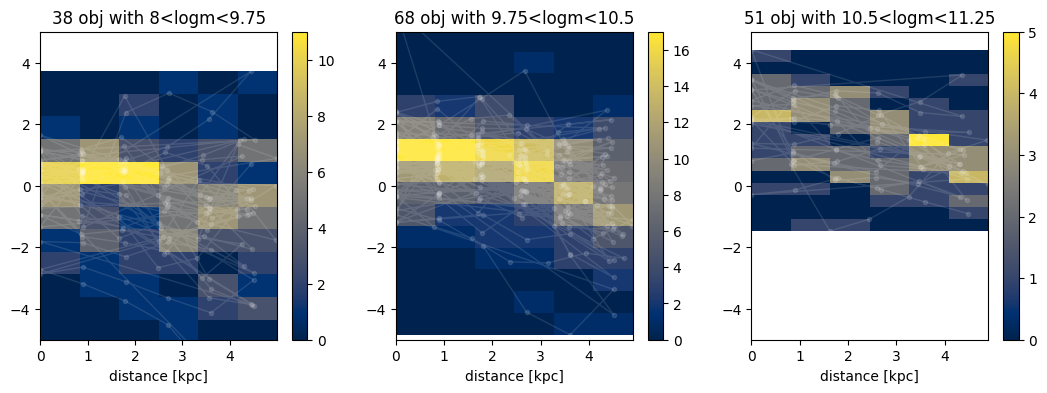

In [40]:
ax =plt.figure(figsize=(13,4))

for i in range(len(bins_m)-1):
    ax.add_subplot(int(f'13{i+1}'))
    r_lis = np.array(()); A_lis = np.array(())
    r_pix_lis = np.array(()); balmer_pix_lis = np.array(())

    for obj in obj_lis_sel[obj_lis_sel['bin_m']==i+1]:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
            r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV',hdu)[1].data).transpose()
            r_lis = np.append(r_lis,r)
            A_lis = np.append(A_lis,A_a)

            distances_obj, balmer_pix, balmer_pix_err = np.vstack(find_data('PIX_RAD_PROFILE',hdu)[1].data).transpose()
            r_pix_lis = np.append(r_pix_lis,distances_obj)
            balmer_pix_lis = np.append(balmer_pix_lis,balmer_pix)
    A_lis[np.isneginf(A_lis)] = np.nan

    mask = np.logical_and(r_lis<5,A_lis<120000)
    #mask = np.logical_and(r_lis<100000,balmer_lis<14000000)
    plt.hist2d(r_lis[mask],A_lis[mask],bins=(6,15),cmap = 'cividis')#, bins=(10,20))
    plt.plot(r_lis[mask],A_lis[mask],linewidth=1,marker='.',color='white',alpha=0.12)
    #plt.xlim(-1,8)
    plt.ylim(-5,5)
    plt.title(f'{len(obj_lis[binning_m==i+1])} obj with {bin_label_m[i]}')
    plt.xlabel('distance [kpc]')
    plt.colorbar()
plt.show()

ValueError: not enough values to unpack (expected 7, got 3)

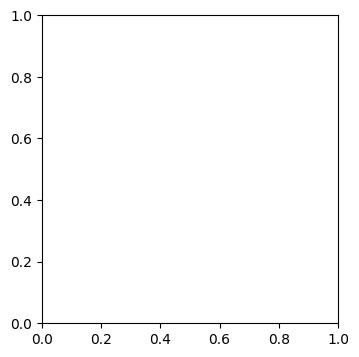

In [17]:
ax =plt.figure(figsize=(13,4))

for i in range(len(bins_m)-1):
    ax.add_subplot(int(f'13{i+1}'))
    r_lis = np.array(()); balmer_lis = np.array(())
    r_pix_lis = np.array(()); balmer_pix_lis = np.array(())

    for obj in obj_lis_sel[obj_lis_sel['bin_m']==i+1]:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
            r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err = np.vstack(find_data('PIX_RAD_PROFILE',hdu)[1].data).transpose()
            r_lis = np.append(r_lis,r)
            balmer_lis = np.append(balmer_lis,balmer_r)

            distances_obj, balmer_pix, balmer_pix_err = np.vstack(find_data('PIX_RAD_PROFILE',hdu)[1].data).transpose()
            r_pix_lis = np.append(r_pix_lis,distances_obj)
            balmer_pix_lis = np.append(balmer_pix_lis,balmer_pix)


    mask = np.logical_and(r_lis<5,balmer_lis<12)
    #mask = np.logical_and(r_lis<100000,balmer_lis<14000000)
    plt.hist2d(r_lr_lis,8);plt.ylim(0,14)
    plt.title(f'{len(obj_lis[binning_m==i+1])} obj with {bin_label_m[i]}')
    plt.xlabel('distance [kpc]')
    plt.axhline(2.86,0,7,linestyle='--',color='white')
    plt.colorbar()
plt.show()

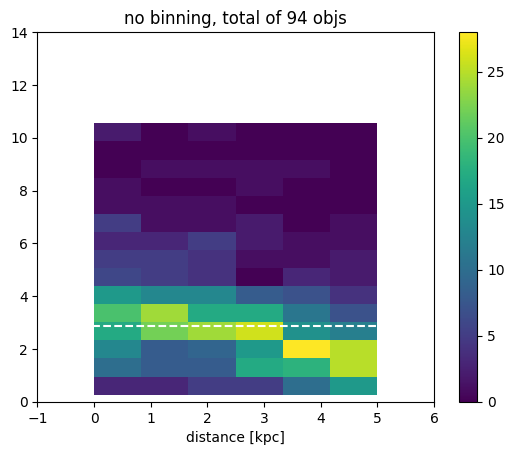

In [14]:
r_lis = np.array(()); balmer_lis = np.array(())
for obj in obj_lis_sel:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
                r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err = np.vstack(find_data('RAD_PROFILE',hdu)[1].data).transpose()

                r_lis = np.append(r_lis,r)
                balmer_lis = np.append(balmer_lis,balmer_r)
                #plt.errorbar(r,balmer_r,yerr = balmer_r_err,linewidth=1,marker='.',elinewidth=0)
                
mask = np.logical_and(r_lis<5,balmer_lis<12)
plt.hist2d(r_lis[mask],balmer_lis[mask],bins=(6,15))#, bins=(10,20))
plt.xlim(-1,6);plt.ylim(0,14)
plt.title(f'no binning, total of {len(obj_lis_sel)} objs')
plt.xlabel('distance [kpc]')
plt.axhline(2.86,0,7,linestyle='--',color='white')
plt.colorbar()

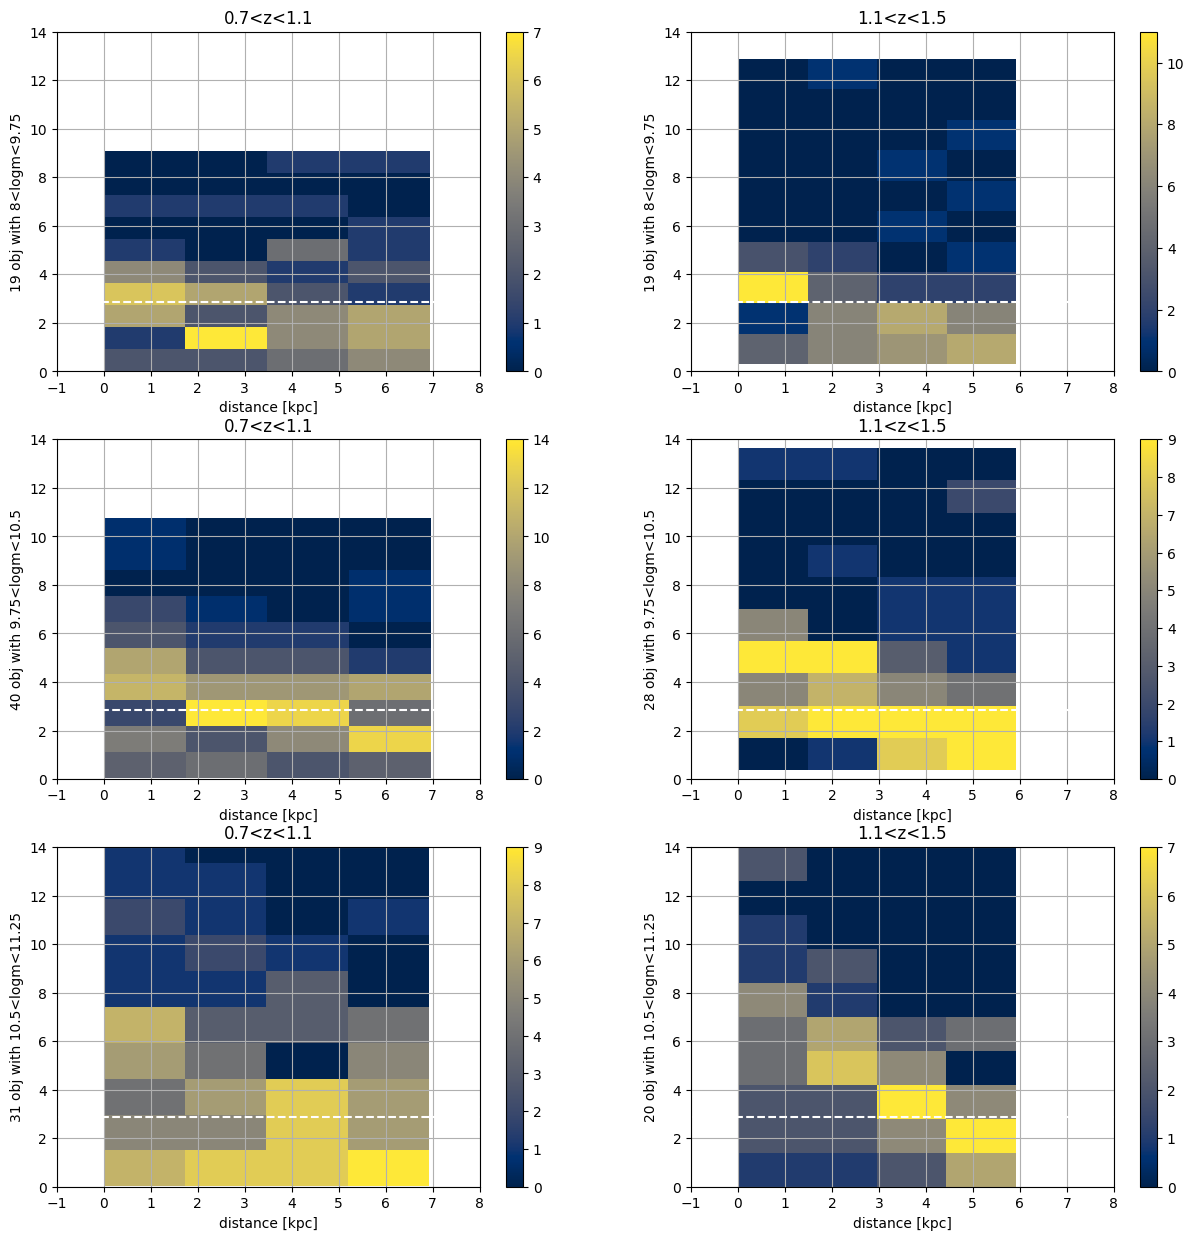

In [40]:
index=1
ax =plt.figure(figsize=(15,15))
for i in range(len(bins_m)-1):
    for j in range(len(bins_z)-1):
        ax.add_subplot(int(f'32{index}'));index+=1
        r_lis = np.array(()); ha_lis = []; hb_lis = []; balmer_lis = np.array(())
        
        for obj in obj_lis[np.logical_and(binning_m==i+1,binning_z==j+1)]:
            path = f"data_extracted/{file_name(obj,prefix='extracted')}"
            with fits.open(path) as hdu:
                r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err = np.vstack(find_data('RAD_PROFILE_CONV',hdu)[1].data).transpose()
                r_lis = np.append(r_lis,r)
                balmer_lis = np.append(balmer_lis,balmer_r)
                #plt.errorbar(r,balmer_r,yerr = balmer_r_err,linewidth=1,marker='.',elinewidth=0)
                
        mask = np.logical_and(r_lis<7,balmer_lis<15)
        plt.hist2d(r_lis[mask],balmer_lis[mask],bins=(4,10),cmap = 'cividis')#, bins=(10,20))
        plt.xlim(-1,8);plt.ylim(0,14)
        plt.title(f'{bin_label_z[j]}')
        plt.ylabel(f'{len(obj_lis[np.logical_and(binning_m==i+1,binning_z==j+1)])} obj with {bin_label_m[i]}')
        plt.xlabel('distance [kpc]')
        plt.colorbar()
        plt.grid()
        plt.axhline(2.86,0,7,linestyle='--',color='white')

plt.show()